In [12]:
# !conda install -c conda-forge librosa

# !conda install tqdm

import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import utils
reload(utils)
import hyperparams
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)

<module 'dcttsModel' from '/home/aduriseti/tts/ettts_master/dcttsModel.py'>

In [13]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [15]:
text2MelParams = hyperparams.Hyperparams(sep=0,pad=0,reversedDilation=1)
# text2MelParams = hyperparams.Hyperparams(sep=0,pad=0,dropout=0,reversedDilation=0)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
text2MelWrapper = utils.ModelWrapper(network=text2Mel,modelName='text2Mel',dev=dev)
text2MelWrapper.load()

INITIALIZED text2Mel WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 1}
TOTAL PARAM COUNT 23949552
HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
LOADED EPOCH 100, LOSS 0.024730781621452588, BEST LOSS 0.024730781621452588 FROM ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar


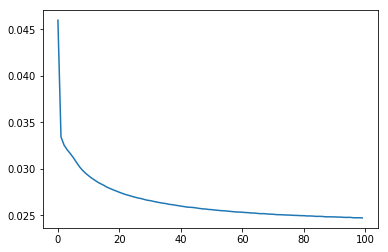

In [17]:
plt.plot(text2MelWrapper.lossHist[:])

In [18]:
ssrnParams = hyperparams.Hyperparams(sep=0)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
ssrnWrapper = utils.ModelWrapper(network=ssrn,modelName='ssrn',dev=dev)
ssrnWrapper.load()

INITIALIZED ssrn WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 0}
TOTAL PARAM COUNT 24980141
HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
LOADED EPOCH 50, LOSS 0.09994267415422112, BEST LOSS 0.09986980878817502 FROM ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar


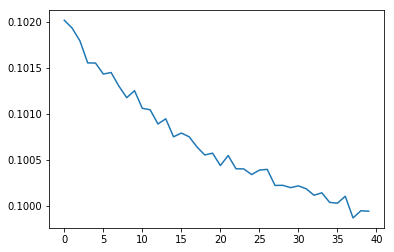

In [19]:
plt.plot(ssrnWrapper.lossHist[10:])

In [20]:
def text2L(text):
    L = ch.Tensor([text2MelParams.c2i[c] for c in text.lower() if c in text2MelParams.c2i])
    L = ch.cat((L,ch.zeros(180-L.shape[0])))
    L = L.type(ch.LongTensor).to(dev)
    return L

texts = ["The birch canoe slid on the smooth planks.",
"Glue the sheet to the dark blue background.",
"It's easy to tell the depth of a well.",
"These days a chicken leg is a rare dish.",
"Rice is often served in round bowls.",
"The juice of lemons makes fine punch.",
"The box was thrown beside the parked truck.",
"The hogs were fed chopped corn and garbage.",
"Four hours of steady work faced us.",
"Large size in stockings is hard to sell.",
'In nineteen seventy two, a crack commando unit was sent to prison by a military court for a crime they didnt commit.',
'These men promptly escaped from the maximum security stockage to the Los Angeles underground.',
'Today, still wanted by the government, they survive as soldiers of fortune.',
'If you have a problem, if no-one else can help, and if you can find them. Maybe you can hire, the A-Team.',
'It is really nostalgic being back at Stanford even though we did not go to school here. By the way, do you know Matt Ye? Panda express Mercedes benz Luftwaffe, Decadent pizza and t'    
]

L = ch.stack([text2L(text) for text in texts])

In [21]:
# dataset = datasets.LJSpeechDataset(ttmel=1)
# idx = np.random.randint(0,dataset.__len__())
# L,S,Y,i = datasets.LJSpeechDataset(ttmel=1).__getitem__(idx)
# L,S,Y = [t.unsqueeze(0).to(dev) for t in (L,S,Y)]
# L.shape,S.shape,Y.shape,i

In [22]:
# initial audio enc
# S = ch.zeros((80,217)).to(dev).unsqueeze(0)
ng,nL = L.shape
s0 = ch.zeros((ng,80,text2MelParams.chunk)).to(dev)
Shat = s0
Shat.shape

torch.Size([15, 80, 1])

In [23]:
with ch.no_grad():
    for t in tqdm.tqdm_notebook(range(218//text2MelParams.chunk)):
        Snext,A = text2Mel(L,Shat[:,:,:])
#         S[:,:,t+1 ] = Shat[:,:,t]
        Shat = ch.cat((s0,Snext),dim=2)
#         Shat = ch.cat((Shat,Snext[:,:,-params.chunk:]),x`dim=2)

Yhat = ssrn(Shat)
Yhat.shape

torch.Size([15, 513, 876])

In [24]:
def toAudio(Y):
    params = ssrnParams
    T = Y ** (params.eta / params.gamma) * 50
    T = T.cpu().detach().numpy().astype(np.float64)
    T = [t.T for t in T]
    for t in T: t[t<0] = 0

    lwsProc = lws.lws(params.nFFT,params.hopL,mode='speech',fftsize=params.nFFT)
    T = [lwsProc.run_lws(t) for t in T]
    T = [lwsProc.istft(t) for t in T]
    return T

for l,t in zip(L,Yhat):
    print("".join(text2MelParams.i2c[i.item()] for i in l))
    ipd.display(ipd.Audio(toAudio(t.unsqueeze(0)),rate=22050))

the birch canoe slid on the smooth planks.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


glue the sheet to the dark blue background.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


its easy to tell the depth of a well.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


these days a chicken leg is a rare dish.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


rice is often served in round bowls.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


the juice of lemons makes fine punch.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


the box was thrown beside the parked truck.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


the hogs were fed chopped corn and garbage.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


four hours of steady work faced us.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


large size in stockings is hard to sell.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


in nineteen seventy two, a crack commando unit was sent to prison by a military court for a crime they didnt commit.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


these men promptly escaped from the maximum security stockage to the los angeles underground.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


today, still wanted by the government, they survive as soldiers of fortune.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


if you have a problem, if no-one else can help, and if you can find them. maybe you can hire, the a-team.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


it is really nostalgic being back at stanford even though we did not go to school here. by the way, do you know matt ye panda express mercedes benz luftwaffe, decadent pizza and tN



today, still wanted by the government, they survive as soldiers of fortune.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


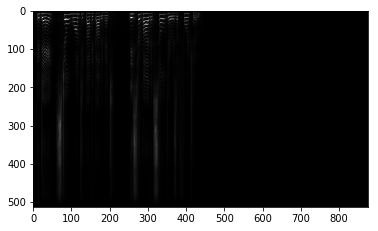

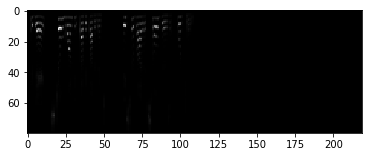

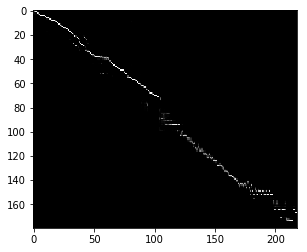

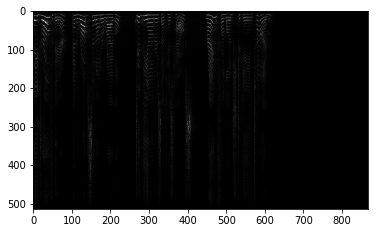

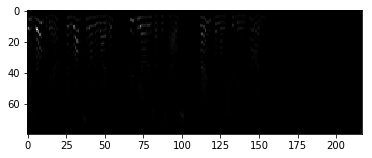

In [27]:
Yhat = ssrn(Shat)

print("".join(text2MelParams.i2c[i.item()] for i in L[0]))
ipd.Audio(toAudio(Yhat),rate=22050)

plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
plt.show()

plt.imshow(Y[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(S[0].cpu().detach().numpy(),cmap='gray')
plt.show()

In [28]:
ipd.Audio(toAudio(Yhat),rate=22050)